In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import torch

/home/maarten/Documents/masterthesis/supervised


In [2]:
num_clusters = 5

files = [f'../clusterlabeled-{num_clusters}/1800{i}.xml' for i in [1, 2, 3, 4, 5]]
small_dataset = data.GermanDatasetInMemory(files, num_clusters, 100, 1000, 3, 0)
medium_dataset = data.GermanDatasetInMemory(files, num_clusters, 500, 5000, 3, 0)

Creating dictionary: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]
685it [00:04, 157.42it/s]                       
Creating dictionary: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]
685it [00:04, 155.37it/s]                        


In [6]:
from collections import namedtuple
ClusterTuple = namedtuple('Clustertuple', ['with_clusters', 'without_clusters'])
models = {}
training_losses = {}
for name, dataset in [('1000 samples', small_dataset), ('5000 samples', medium_dataset)]:
    traindata, testdata = dataset.split(0.3)

    params = train.CNNParams(
        embed_size=300,
        dropout=0.50,
        epochs=25,
        num_filters=100
    )

    optimizer = lambda params: torch.optim.Adadelta(params, weight_decay=0.001)
    model, losses = train.setup_and_train(params, with_labels=False, dataset=traindata,
                                          epochs=params.epochs, batch_size=50, optim_fn=optimizer)
    cluster_model, cluster_losses = train.setup_and_train(params, with_labels=True,
                                                          dataset=traindata, epochs=params.epochs,
                                                          batch_size=50, optim_fn=optimizer)
    
    models[name] = ClusterTuple(cluster_model, model)
    training_losses[name] = ClusterTuple(cluster_losses, losses)

Training: 100%|██████████| 25/25 [00:48<00:00,  1.94s/it, loss=0.365, Δloss=-0.00989]


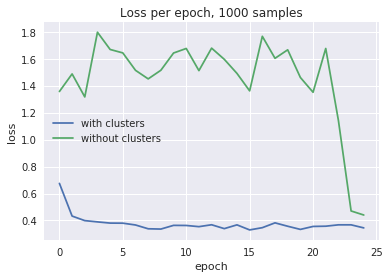

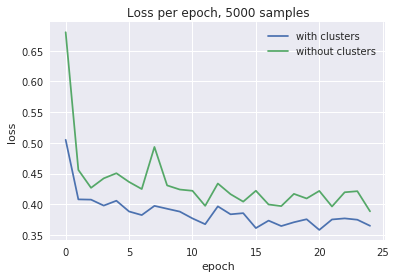

In [10]:
for name, loss in training_losses.items():
    evaluate.plot({'with clusters': loss.with_clusters, 'without clusters': loss.without_clusters},
                  'epoch', 'loss', False, f'Loss per epoch, {name}')
    evaluate.plt.figure();

1000 samples
----
Average precision with clusters: 0.8815129667140844
Average precision without clusters: 0.7174104786964449

5000 samples
----
Average precision with clusters: 0.8839372147597779
Average precision without clusters: 0.8665015211889522



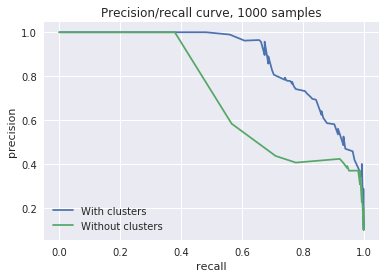

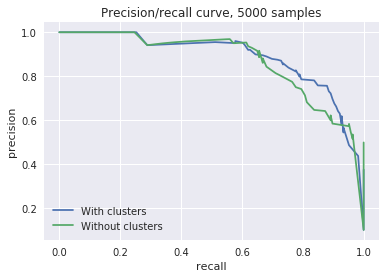

In [13]:
for name, model in models.items():
    print(name)
    print('----')
    nocluster_p, nocluster_r = evaluate.precision_recall_values(model.without_clusters, data.get_iterator(testdata, [40]))
    cluster_p, cluster_r = evaluate.precision_recall_values(model.with_clusters, data.get_iterator(testdata, [40]));
    evaluate.plot({'With clusters': (cluster_r, cluster_p), 'Without clusters': (nocluster_r, nocluster_p)},
              'recall', 'precision', title=f'Precision/recall curve, {name}')
    evaluate.plt.figure()

    print(f'Average precision with clusters: {evaluate.average_precision(cluster_p, cluster_r)}')
    print(f'Average precision without clusters: {evaluate.average_precision(nocluster_p, nocluster_r)}')
    print()

# Older data

This section tests the trained models on a number of files from the older wahlperiods.

In [ ]:
import os
files = os.listdir(f'../testing_data_older-{num_clusters}/')
paths = [f'../testing_data_older-{num_clusters}/' + f for f in files]
old_data = data.GermanDatasetInMemory(paths, num_clusters, 10000, 10000, 3, 0, vocab=traindata.vocab)

In [ ]:
old_nocluster_p, old_nocluster_r = evaluate.precision_recall_values(model, data.get_iterator(old_data, [40]))
old_cluster_p, old_cluster_r = evaluate.precision_recall_values(label_model, data.get_iterator(old_data, [40]));

evaluate.plot({'With clusters': (old_cluster_r, old_cluster_p), 'Without clusters': (old_nocluster_r, old_nocluster_p)},
              'recall', 'precision', title='Precision/recall curve')

print(f'Average precision with clusters: {evaluate.average_precision(old_cluster_p, old_cluster_r)}')
print(f'Average precision without clusters: {evaluate.average_precision(old_nocluster_p, old_nocluster_r)}')